# Daedalus: Autoencoder and GAN

## setup

In [1]:
from collections import deque
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## helpers

### maze generator

In [2]:
# hyperparameters
MOVES = [
    (-1, 0), # up
    (1, 0),  # down
    (0, -1), # left
    (0, 1),  # right
]

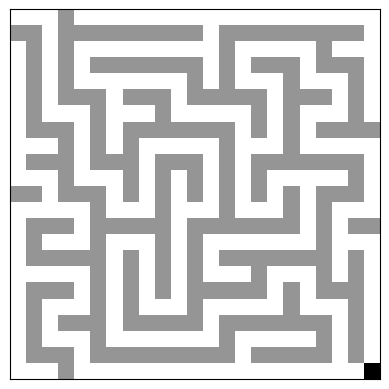

In [3]:
# maze generator
def make_maze(width):
    maze = torch.zeros((width, width))
    def add_exit(maze):
        choices = (maze == 1).nonzero().tolist()
        furthest = max(choices, key=lambda x: x[0] + x[1])
        maze[furthest[0], furthest[1]] = -1

    def rec(x, y):
        while True:
            pairs = []
            for move in MOVES:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 1, 1
            rec(nnx, nny)

    maze[0, 0] = 1
    rec(0, 0)
    add_exit(maze)
    return maze

def ascii_maze(maze):
    lookup = {0: '@', 1: '_', -1: 'x'}
    print('\n'.join(''.join(lookup[i] for i in row) for row in maze.tolist()))

def plot_maze(maze, ax=None, figsize=None):
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    ax.imshow(-maze, 'Greys')
    ax.set_xticks([])
    ax.set_yticks([])

# look at the maze
maze = make_maze(23)
plot_maze(maze)
# ascii_maze(maze)

In [4]:
# maze generator
def make_maze_steps(width):
    maze = torch.zeros((width, width))
    steps = []

    def rec(x, y):
        while True:
            pairs = []
            for move in MOVES:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 2, 2
            cp = copy.deepcopy(maze)
            cp[nx, ny], cp[nnx, nny] = 1, 1
            steps.append(cp)
            steps.append(copy.deepcopy(maze))
            rec(nnx, nny)

    maze[0, 0] = 2
    rec(0, 0)
    return steps

In [5]:
def get_frame(steps, ax):
    def f(d):
        ax.clear()
        ax.set_title(f'step {d // 2}')
        plot_maze(steps[d], ax=ax)
    return f

steps = make_maze_steps(23)
fig, ax = plt.subplots(figsize=(3, 3))
ani = FuncAnimation(fig, get_frame(steps, ax), frames=len(steps), interval=50, repeat=False)
plt.close()

display(HTML(ani.to_jshtml())) # display inline
ani.save('maze-creation.gif', fps=20) # save to disk

### distances to exit

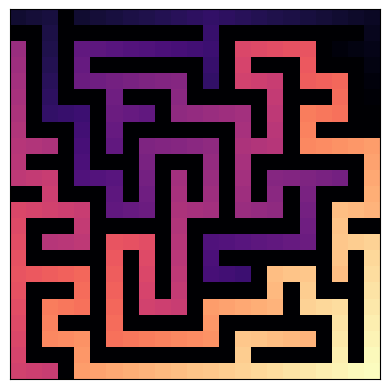

In [6]:
# compute optimal distances to the exit
def dists(maze):
    MAZE_WIDTH = maze.shape[0]
    pos = tuple((maze == -1).nonzero().tolist()[0]) # locate the exit
    dist = torch.zeros_like(maze)
    seen = set()
    q = deque()
    q.append((pos, 0))
    while q:
        pos, d = q.popleft()
        if pos in seen: continue
        if maze[pos] == 0: continue
        seen.add(pos)
        dist[pos] = d
        for move in MOVES:
            new_pos = (pos[0] + move[0], pos[1] + move[1])
            if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
                q.append((new_pos, d + 1))
    return dist

def formatted_dists(maze):
    dist = dists(maze)
    unreachable = (dist == 0) & (maze == 1)
    # revert distances for plotting
    mask = maze != 0
    dist[mask] = dist.max() - dist[mask]
    # hide unreachable
    dist[unreachable] = torch.nan
    return dist

def plot_dists(maze, ax=None, figsize=None):
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    dist = formatted_dists(maze)
    ax.imshow(dist, cmap=plt.cm.magma, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

plot_dists(maze)

In [7]:
def get_frame(maze, ds, ax):
    def f(step):
        mz = copy.deepcopy(ds)
        mz[ds > step] = 0.
        mask = maze != 0
        mz[mask] = ds.max() - mz[mask]
        ax.clear()
        ax.set_title(f'step {step}')
        ax.imshow(mz, cmap=plt.cm.magma, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
    return f

def animate_dists(maze, figsize=(3, 3)):
    ds = dists(maze)
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(maze, ds, ax), frames=int(ds.max().item()) + 1, interval=50, repeat=False)
    plt.close()
    return ani

ani = animate_dists(maze)
display(HTML(ani.to_jshtml())) # display inline
ani.save('maze-dists.gif', fps=20) # save to disk

### plot

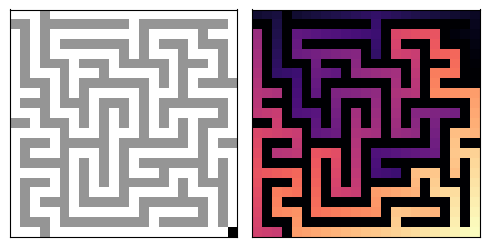

In [8]:
# plot maze and distances side by side
def plotm(maze, figsize=(5, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_maze(maze, ax=ax[0])
    plot_dists(maze, ax=ax[1])
    fig.tight_layout()

plotm(maze)

In [9]:
def plot(*args, n_col=None, figsize=None, block_size=3, dist=False):
    '''Plot the mazes in a grid
    usage: plot(maze1, maze2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1, dist=False

    maze: torch.Tensor of shape (H, W)
    '''
    mazes = args
    # unpack a batch into a list of mazes
    if len(mazes) == 1 and isinstance(mazes[0], torch.Tensor) and mazes[0].dim() == 4:
        mazes = [mazes[0][i] for i in range(mazes[0].shape[0])]
    # flatten channels
    mazes = [maze.squeeze(0) if maze.dim() == 3 else maze for maze in mazes]
    mazes = [maze.detach().cpu() for maze in mazes]

    if n_col is None: n_col = len(mazes)
    n_row = math.ceil(len(mazes) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    if dist: mazes = [formatted_dists(m) for m in mazes]
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    # plot
    for i, maze in enumerate(mazes):
        idx = (i // n_col, i % n_col)
        if dist: ax[*idx].imshow(maze, cmap=plt.cm.magma, interpolation='nearest')
        else: ax[*idx].imshow(-maze, 'Greys')
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[*idx].set_xticks([])
        ax[*idx].set_yticks([])
        if i >= len(mazes): ax[*idx].axis('off')
    plt.tight_layout()
    plt.show()

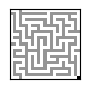

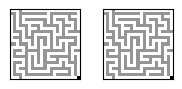

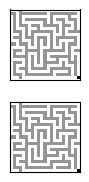

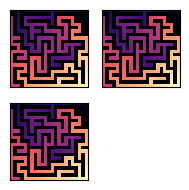

In [10]:
# test plot function
plot(maze, block_size=1)
plot(maze, maze, block_size=1)
plot(maze, maze, n_col=1, block_size=1)
plot(maze, maze, maze, n_col=2, block_size=1, dist=True)

## Autoencoder / VAE

### theory
- autoencoder: https://arxiv.org/pdf/2003.05991.pdf
- VAE: https://arxiv.org/pdf/1312.6114.pdf
- VQ-VAE: https://arxiv.org/pdf/1711.00937.pdf
- NVAE: https://arxiv.org/pdf/2007.03898.pdf

### setup

In [11]:
# hyperparameters
LEARNING_RATE = 3e-4

### model

In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        # encoding
        nn.Conv2d(
            in_channels=1,
            out_channels=3,
            kernel_size=5,
            stride=1,
            padding='same',
        ),
        nn.ReLU(),
        # nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(
            in_channels=3,
            out_channels=3,
            kernel_size=3,
            stride=2,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=3,
            stride=2,
        ),
        nn.ReLU())
    # bottleneck lives here → ←
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=6,
            out_channels=6,
            kernel_size=2,
            stride=2,
        ),
        nn.ReLU(),
        nn.ConvTranspose2d(
            in_channels=6,
            out_channels=3,
            kernel_size=5,
            stride=2,
        ),
        nn.ReLU(),
        nn.ConvTranspose2d(
            in_channels=3,
            out_channels=1,
            kernel_size=2,
            stride=1,
        ),
        nn.Sigmoid())

  def forward(self,x):
    x = self.encoder(x)
    return self.decoder(x)

m = Net()
maze = make_maze(32)
m(maze.view(1, 1, 32, 32)).shape

torch.Size([1, 1, 32, 32])

### train

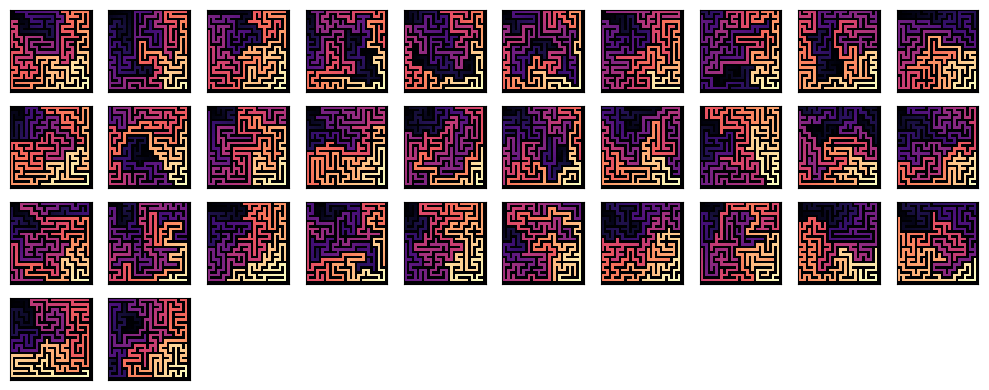

In [13]:
def get_batch(maze_size=32, batch_size=32):
    mazes = [make_maze(maze_size) for _ in range(batch_size)]
    return torch.stack(mazes).view(batch_size, 1, maze_size, maze_size).to(device)

batch = get_batch()
plot(batch, block_size=1, n_col=10, dist=True)

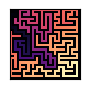

In [14]:
validation_batch = get_batch(batch_size=1)
plot(validation_batch, block_size=1, dist=True)

In [15]:
autoencoder = Net().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-8)
losses = []
validation_losses = []

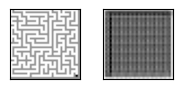

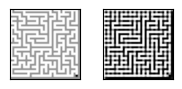

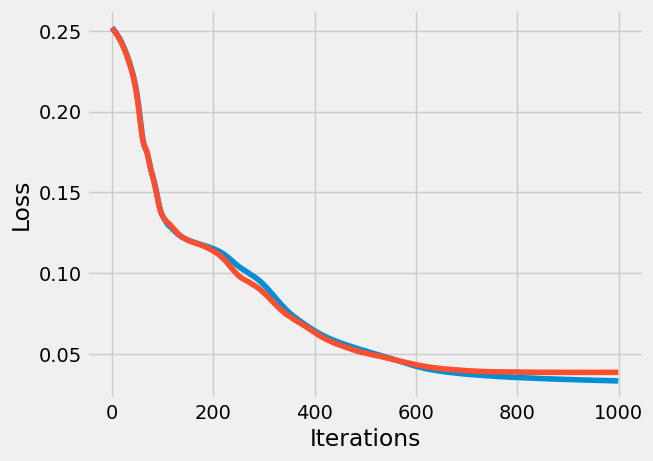

In [16]:
epochs = 1000

for epoch in range(epochs):
	maze_outputs = autoencoder(batch)
	loss = F.mse_loss(maze_outputs, batch)
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	# Storing the losses in a list for plotting
	losses.append(loss)

	# Validation Loss
	with torch.no_grad():
		prediction = autoencoder(validation_batch)
		validation_loss = F.mse_loss(prediction, validation_batch)
		validation_losses.append(validation_loss)

	if epoch % 500 == 0:
		with torch.no_grad():
			one_maze = batch[0].view(32, 32)
			reconstructed_maze = autoencoder(one_maze.view(1, 1, 32, 32)).view(32, 32)
			plot(one_maze, reconstructed_maze, block_size=1)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot([l.detach().cpu() for l in losses])
plt.plot([l.detach().cpu() for l in validation_losses])

### exploitation

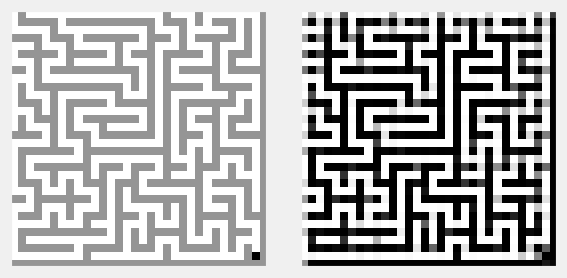

In [17]:
# plot the overfit thing from training set
generated = autoencoder(batch)
plot(batch[0], generated[0])

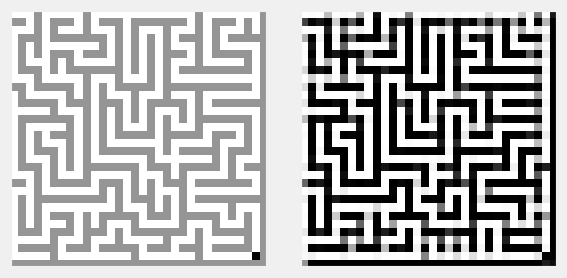

In [18]:
# plot the validation
generated = autoencoder(validation_batch)
plot(validation_batch[0], generated[0])

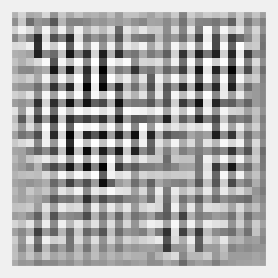

In [19]:
# generate random crap
latent = torch.randn((1,6,7,7)).to(device)
generated = autoencoder.decoder(latent)
plot(generated[0])

## VAE

### model

In [20]:
class VaeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # encoding
            nn.Conv2d(
                in_channels=1,
                out_channels=3,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=3,
                out_channels=3,
                kernel_size=3,
                stride=2,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=3,
                out_channels=12,
                kernel_size=3,
                stride=2,
            ),
            nn.ReLU())
        # bottleneck lives here → ←
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=6,
                out_channels=6,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=6,
                out_channels=6,
                kernel_size=7,
                stride=1,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=6,
                out_channels=6,
                kernel_size=7,
                stride=1,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=6,
                out_channels=6,
                kernel_size=6,
                stride=1,
            ),
            nn.ReLU(),
            # nn.ConvTranspose2d(
            #     in_channels=6,
            #     out_channels=3,
            #     kernel_size=5,
            #     stride=2,
            # ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=6,
                out_channels=1,
                kernel_size=2,
                stride=1,
            ),
            nn.Sigmoid())

    # # Calculate the KL divergence loss
    # def kl_divergence(self, means, logvars):
    #     return -0.5 * torch.sum(1 + logvars - means.pow(2) - logvars.exp())

    # def sample(self, means, logvars):
    #     rando = torch.randn_like(means).to(device)
    #     latent = means + torch.exp(0.5 * logvars) * rando
    #     return latent

    def kl_divergence(self, means, stds):
        return F.mse_loss(means, torch.zeros_like(means)) + F.mse_loss(stds, torch.ones_like(stds))

    def sample(self, means, stds):
        rando = torch.randn_like(means).to(device) * 0.1
        latent = means + stds * rando
        return latent

    def forward(self,x):
        x = self.encoder(x)
        n_channels = x.shape[1] // 2
        means = x[:, :n_channels, :, :]
        stds = x[:, n_channels:, :, :]
        latent = self.sample(means, stds)
        # latent = torch.ones_like(latent)
        return self.decoder(latent), self.kl_divergence(means, stds)

m = VaeNet().to(device)
maze = make_maze(32).to(device)
out, kl = m(maze.view(1, 1, 32, 32))
out.shape

torch.Size([1, 1, 32, 32])

In [21]:
LATENT_DIM = 1280
class VaeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 4x4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * LATENT_DIM)  # Output: 2 * latent_dim (mean and log-variance)
        )
        self.fc = nn.Sequential(
            nn.Linear(LATENT_DIM, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128*4*4),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: 32x32
            nn.Sigmoid()  # Use sigmoid to output values between 0 and 1
        )

    def kl_divergence(self, means, logvars):
        # return F.mse_loss(means, torch.zeros_like(means)) + F.mse_loss(logvars, torch.ones_like(logvars))
        return -0.5 * torch.sum(1 + logvars - means.pow(2) - logvars.exp())

    def sample(self, means, logvars):
        stds = torch.exp(0.5 * logvars)
        eps = torch.randn_like(stds) * 0.1
        return means + eps * stds

    def forward(self, x):
        x = self.encoder(x)
        n_channels = x.shape[1] // 2
        means = x[:, :n_channels]
        logvars = x[:, n_channels:,]
        latent = self.sample(means, logvars)
        latent = self.fc(latent)
        latent = latent.view(-1, 128, 4, 4) 
        # latent = torch.ones_like(latent)
        return self.decoder(latent), self.kl_divergence(means, logvars)

m = VaeNet().to(device)
maze = make_maze(32).to(device)
out, kl = m(maze.view(1, 1, 32, 32))
out.shape


torch.Size([1, 1, 32, 32])

In [ ]:
from datasets import load_dataset

dataset = load_dataset('mnist')
xs = dataset['train']
def get_mnist_batch(batch_size=32):
    return torch.stack([F.pad(torch.tensor(np.array(x) / 255.), (2, 2, 2, 2), "constant", 0).unsqueeze(0) for x in xs[:batch_size]['image']]).float().to(device)

get_mnist_batch(2).shape

In [23]:
display(xs[2]['image'])

In [24]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*4*4, 2*latent_dim)  # Output: latent_dim means and latent_dim log_vars
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Sigmoid activation to get binary output
        )
        
    def kl_divergence(self, means, logvars):
        return -0.5 * torch.sum(1 + logvars - means.pow(2) - logvars.exp())

    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)
        mu, log_var = encoded.chunk(2, dim=1)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparameterization trick

        # Decoder
        reconstructed = self.decoder(z)
        return reconstructed, self.kl_divergence(mu, log_var)

latent_dim = 64  # Example latent dimension, adjust as needed
latent_dim = 256  # Example latent dimension, adjust as needed
latent_dim = 7  # Example latent dimension, adjust as needed
vae = VAE(latent_dim).to(device)
maze = make_maze(32).to(device).view(1, 1, 32, 32)
vae(maze)[0].shape

torch.Size([1, 1, 32, 32])

In [25]:
# try fully connected no conv?
class VAE(nn.Module):
    def __init__(self, latent_dim, width=32, hidden=128):
        super(VAE, self).__init__()
        in_size = width * width
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, in_size),
            nn.Unflatten(1, (32, 32)),
            nn.Sigmoid(),
        )
        
    def kl_divergence(self, means, logvars):
        return -0.5 * torch.sum(1. + 2 * logvars - means.pow(2) - logvars.exp().pow(2))

    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)
        z = encoded
        # mu, log_var = encoded.chunk(2, dim=1)
        # print(f'{mu.shape=} {log_var.shape=}')
        # std = torch.exp(0.5 * log_var)
        # eps = torch.randn_like(std)
        # z = mu + eps * std  # Reparameterization trick
 
        # Decoder
        reconstructed = self.decoder(z)
        return reconstructed, 0.
        # return reconstructed, self.kl_divergence(mu, log_var)

latent_dim = 64  # Example latent dimension, adjust as needed
latent_dim = 3000  # Example latent dimension, adjust as needed
# latent_dim = 32  # Example latent dimension, adjust as needed
vae = VAE(latent_dim, hidden=3000).to(device)
maze = make_maze(32).to(device).view(1, 1, 32, 32)
vae(maze)[0].shape

torch.Size([1, 32, 32])

# x

In [268]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32),
            nn.Unflatten(1, (1, 32, 32)),
            nn.Sigmoid()
        )

    def kl(self, mu, log_var):
        # return 0.5 * torch.sum(mu**2 + log_var.exp()**2 - log_var -1)
        # return 0
        # log_var.exp() == std()**2
        return -0.5 * torch.sum(1 + log_var + mu.pow(2) - log_var.exp())
        # return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # return 0.2 * (F.mse_loss(log_var.exp(), torch.ones_like(log_var)) + F.mse_loss(mu, torch.zeros_like(mu)))
        # return (F.mse_loss(log_var.exp(), torch.ones_like(log_var)) + F.mse_loss(mu, torch.zeros_like(mu))) / self.latent_dim

    def forward(self, x):
        encoded = self.encoder(x)
        mu, log_var = encoded.chunk(2, dim=1)
        r = torch.randn_like(mu)
        # encoded = mu + log_var.exp() * r
        encoded = mu + log_var.exp().sqrt() * r
        decoded = self.decoder(encoded)
        return decoded, self.kl(mu, log_var)  # Reshape back to the original image dimensions

autoencoder = SimpleAutoencoder(latent_dim=64).to(device)
# was 64

batch = get_mnist_batch(batch_size=32)
# batch = get_mnist_batch(batch_size=320)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)
losses = []
p_losses = []
kl_losses = []
epochs = 3000

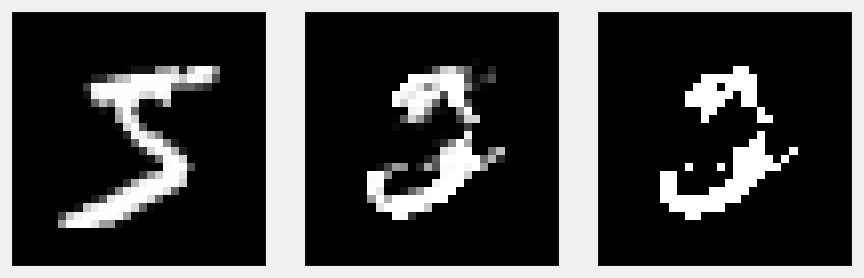

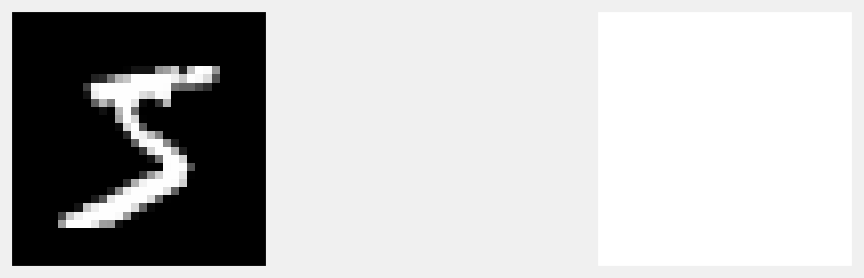

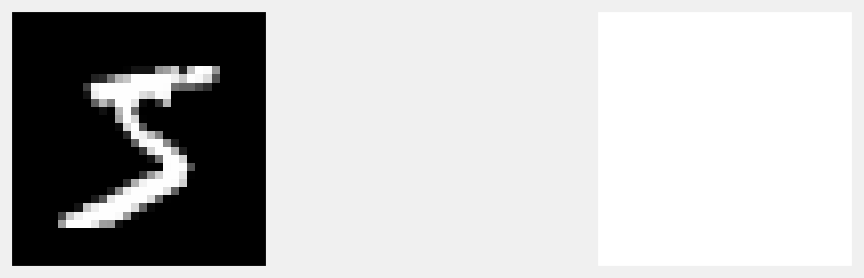

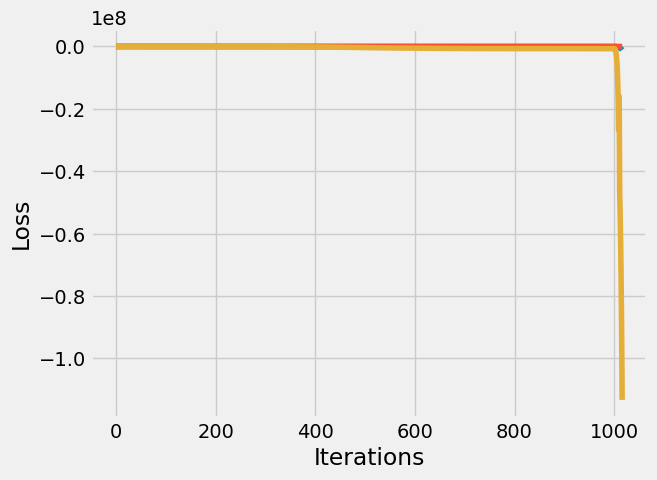

In [266]:

for epoch in range(epochs):
    maze_outputs, kl = autoencoder(batch)
    # print(f'{maze_outputs.shape=} {batch.shape=}')
    # loss = F.mse_loss(maze_outputs, batch) / (32*32) + kl
    p_loss = F.mse_loss(maze_outputs, batch)
    # p_loss = torch.sum((maze_outputs - batch)**2)
    kl_loss = kl
    loss = p_loss + kl_loss 
    # loss = torch.mean(p_loss + kl_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Storing the losses in a list for plotting
    p_losses.append(p_loss)
    kl_losses.append(kl_loss)
    losses.append(loss)

    if epoch % 500 == 0:
        with torch.no_grad():
            width = batch.shape[3]
            one_maze = batch[0].view(width, width)
            reconstructed_maze, _ = autoencoder(one_maze.view(1, 1, width, width))
            reconstructed_maze = reconstructed_maze.view(width, width)
            plot(one_maze, reconstructed_maze, (reconstructed_maze > 0.5).float(), block_size=3)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot([l.detach().cpu() for l in losses])
plt.plot([l.detach().cpu() for l in p_losses])
plt.plot([l.detach().cpu() for l in kl_losses])


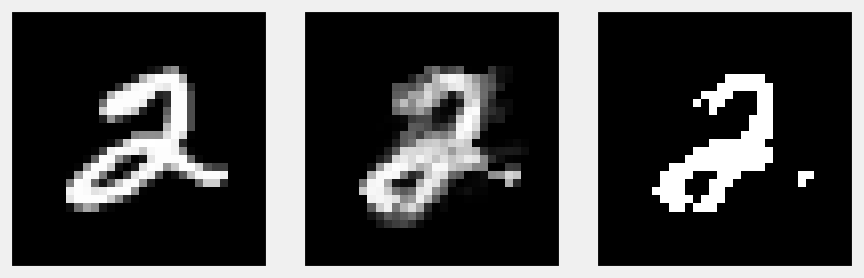

In [226]:
control = get_mnist_batch(batch_size=64)[32:, :, :, :]
width = batch.shape[3]
one_maze = batch[5].view(width, width)
# one_maze = control[28].view(width, width)
reconstructed_maze, _ = autoencoder(one_maze.view(1, 1, width, width))
reconstructed_maze = reconstructed_maze.view(width, width)
plot(one_maze, reconstructed_maze, (reconstructed_maze > 0.5).float(), block_size=3)

# y

In [253]:
width = batch.shape[3]
one_maze = batch[2].view(width, width)
latent = autoencoder.encoder(one_maze.view(1, 1, width, width))
mu, log_var = latent.chunk(2, dim=1)
print(log_var.max(), mu.max())


# r = torch.randn_like(mu)
# encoded = mu + torch.exp(0.5 * log_var) * r

# for i in range(64):
#     cp = copy.deepcopy(encoded.detach().cpu()).to(device)
#     print(f'{i=}')
#     cp[0][i] += 10
#     reconstructed_maze = autoencoder.decoder(cp).view(width, width)
#     plot(one_maze, reconstructed_maze, (reconstructed_maze > 0.5).float(), block_size=2)

tensor(0.0186, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0198, device='cuda:0', grad_fn=<MaxBackward1>)


# https://avandekleut.github.io/vae/
https://arxiv.org/pdf/1903.10145.pdf

In [274]:
dataset = load_dataset('mnist')
xs = dataset['train']
def get_mnist_batch_r(batch_size=32):
    xs.shuffle()
    return torch.stack([F.pad(torch.tensor(np.array(x) / 255.), (2, 2, 2, 2), "constant", 0).unsqueeze(0) for x in xs[:batch_size]['image']]).float().to(device)


In [282]:
import torchvision

In [288]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)
# data = get_mnist_batch(batch_size=12800)
autoencoder = train(autoencoder, data)

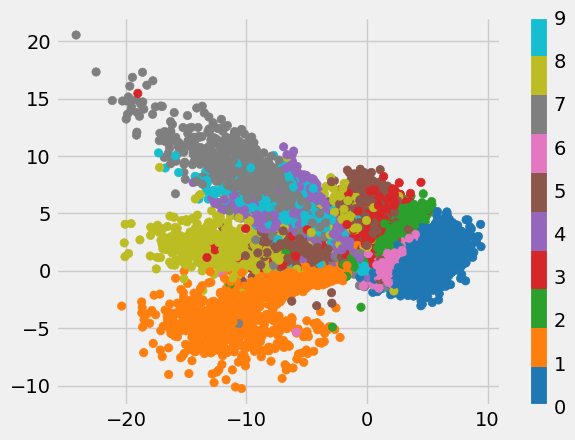

In [289]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
plot_latent(autoencoder, data)

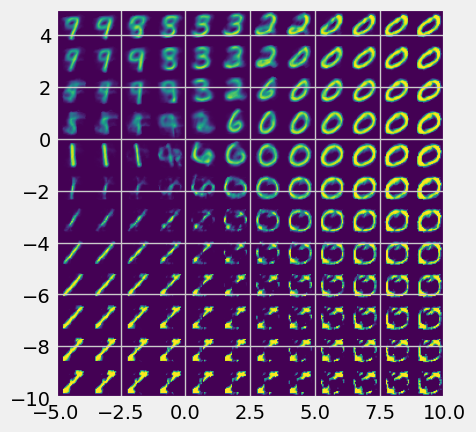

In [290]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(autoencoder)

In [292]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

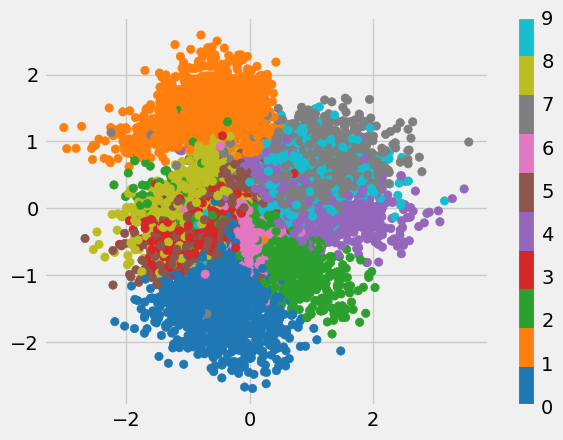

In [293]:
plot_latent(vae, data)

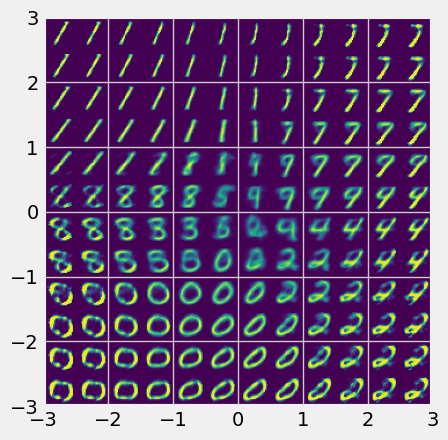

In [294]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

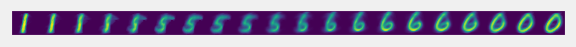

In [301]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

for x, y in data: # hack to grab a batch
    x_1 = x[y == 1][1].to(device) # find a 1
    x_2 = x[y == 0][1].to(device) # find a 0
    interpolate(vae, x_1, x_2, n=20)
    break

## mess with it

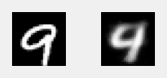

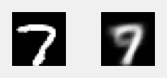

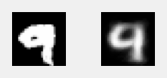

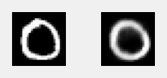

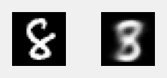

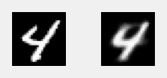

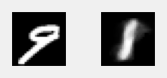

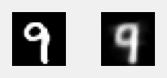

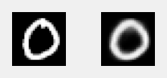

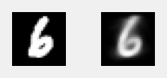

In [321]:
for x, _ in data:
    for i in range(10):
        plot(x[i].squeeze(0), vae(x[i].to(device)).squeeze(0), block_size=1)
    break


# z

### train

In [27]:
batch = get_batch(batch_size=2)
batch = get_mnist_batch(batch_size=2)
# batch = torchvision.transforms.functional.resize(batch, (32*3, 32*3), interpolation=torchvision.transforms.InterpolationMode.NEAREST)

In [28]:
# vae = VaeNet().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4) #, weight_decay=1e-8)
losses = []
validation_losses = []

C:\Users\p\AppData\Local\Temp\ipykernel_69920\703367245.py:5: UserWarning: Using a target size (torch.Size([2, 1, 32, 32])) that is different to the input size (torch.Size([2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  maze_loss = F.mse_loss(maze_outputs, batch)
C:\Users\p\AppData\Local\Temp\ipykernel_69920\703367245.py:17: UserWarning: Using a target size (torch.Size([1, 1, 32, 32])) that is different to the input size (torch.Size([1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  validation_maze_loss = F.mse_loss(prediction, validation_batch)


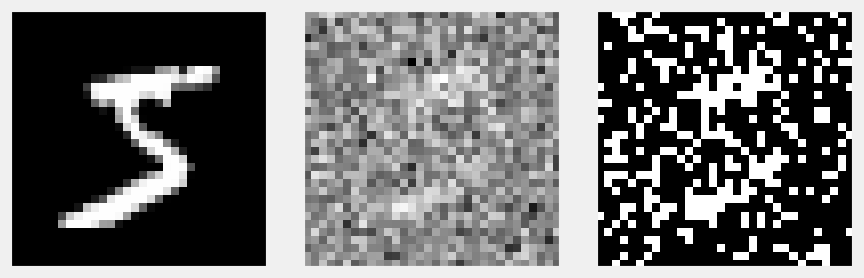

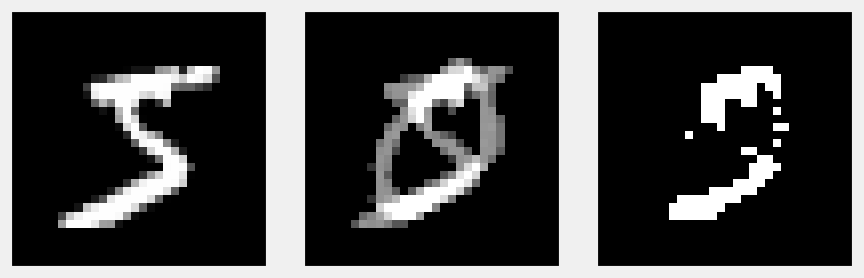

KeyboardInterrupt: 

In [29]:
epochs = 3000

for epoch in range(epochs):
	maze_outputs, latent_loss = vae(batch)
	maze_loss = F.mse_loss(maze_outputs, batch)
	loss = maze_loss + latent_loss
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	# Storing the losses in a list for plotting
	losses.append(loss)

	# Validation Loss
	with torch.no_grad():
		prediction, validation_latent_loss = vae(validation_batch)
		validation_maze_loss = F.mse_loss(prediction, validation_batch)
		validation_loss = validation_maze_loss # + validation_latent_loss
		validation_losses.append(validation_loss)

	if epoch % 500 == 0:
		with torch.no_grad():
			width = batch.shape[3]
			one_maze = batch[0].view(width, width)
			reconstructed_maze, _ = vae(one_maze.view(1, 1, width, width))
			reconstructed_maze = reconstructed_maze.view(width, width)
			plot(one_maze, reconstructed_maze, (reconstructed_maze > 0.5).float(), block_size=3)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot([l.detach().cpu() for l in losses])
plt.plot([l.detach().cpu() for l in validation_losses])

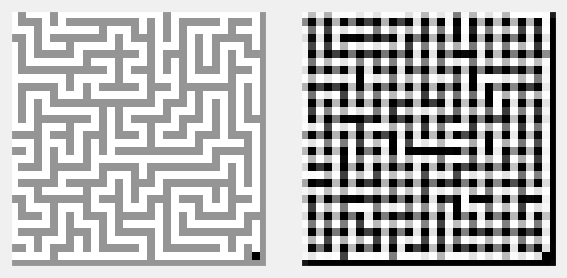

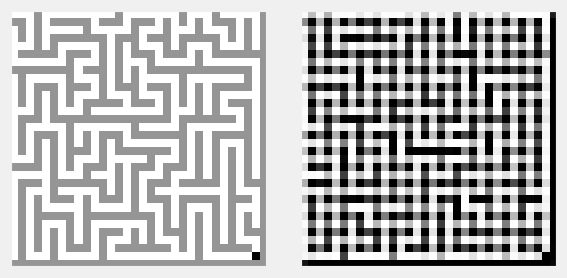

In [ ]:
# plot the overfit thing from training set
generated, _ = vae(batch)
plot(batch[0], generated[0])
plot(batch[1], generated[1])


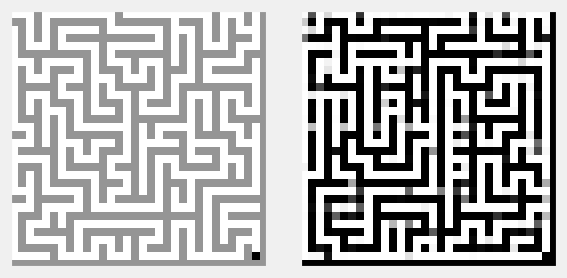

In [ ]:
# plot the validation
generated, _ = vae(validation_batch)
plot(validation_batch[0], generated[0])

In [ ]:
# generate random crap
# latents = vae.encoder(batch)
# generated = vae.decoder(latents)

# plot(batch[0], generated[0])l

## GAN

### theory
https://arxiv.org/pdf/1406.2661.pdf

$\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x\sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))].$

### setup

In [ ]:
# hyperparameters
LEARNING_RATE = 3e-4

### generator

### discriminator

### train

### exploitation